In [1]:
import pandas as pd
import os

In [2]:
# Загрузка датафрейма на 5к строк
df1 = pd.read_csv("IMDB_Movies_Dataset.csv")

# Загрузка датафрейма на 130к строк
df2 = pd.read_csv("IMBD.csv")

# Проверим, что считали
df1.head()
df2.head()

,movie,genre,runtime,certificate,rating,stars,description,votes,director
0,The Witcher,"Action, Adventure, Drama",60 min,A,8.1,"['Henry Cavill, ', 'Freya Allan, ', 'Anya Chal...","Geralt of Rivia, a solitary monster hunter, st...","5,39,085",NaN
1,Mission: Impossible - Dead Reckoning Part One,"Action, Adventure, Thriller",163 min,UA,8.0,"['Tom Cruise, ', 'Hayley Atwell, ', 'Ving Rham...",Ethan Hunt and his IMF team must track down a ...,"1,06,759",['Christopher McQuarrie']
2,Sound of Freedom,"Action, Biography, Drama",131 min,PG-13,7.9,"['Jim Caviezel, ', 'Mira Sorvino, ', 'Bill Cam...",The incredible true story of a former governme...,"41,808",['Alejandro Monteverde']
3,Secret Invasion,"Action, Adventure, Drama",47 min,UA 16+,6.2,"['Samuel L. Jackson, ', 'Emilia Clarke, ', 'Do...",Fury and Talos try to stop the Skrulls who hav...,"40,536",NaN
4,Special Ops: Lioness,"Action, Drama, Thriller",NaN,NaN,7.5,"['Zoe Saldana, ', 'Laysla De Oliveira, ', 'Dav...",Joe attempts to balance her personal and profe...,"3,203",NaN


In [3]:
# обработка столбца с указанием директоров для объединения дф-ов
l = []
for i in df2['director'].to_list():
    if str(i) == 'nan':
        l.append('')
    else:
        l.append(str(i)[2:len(i)-2])
df2['director'] = l  

# объединение дф-ов по полям "Название" и "Средний рейтинг"
df3 = (pd.merge(df1, df2, how = 'inner',
               left_on = ['Title', 'Director'], right_on = ['movie', 'director'])
          .drop_duplicates(['Title', 'Average Rating'])) 

In [4]:
# создание функции для приведения заголовков к единому виду с учётом повторяющихся наименований столбцов
def replace_col_names(columns_names):
    l = list()
    for i in columns_names:
        if i not in l:
            l.append(i.lower().replace(' ', '_'))
        else:
            l.append(i.lower().replace(' ', '_')+'2')
    return l

# приведение заголовков датафрейма к единому формату
df3.columns = replace_col_names(df3.columns)    

# обрезка датафрейма
df3 = df3[['title', 'average_rating', 'director', 'writer',
           'metascore', 'cast', 'release_date', 'country_of_origin', 
           'languages', 'runtime2','genre', 'budget', 'worldwide_gross']] 

# доработка наименований столбцов после обрезки датафрейма
df3 = df3.rename(columns = {'runtime2': 'runtime'}) 

In [5]:
# создание столбца "Год выпуска"
df3['release_year'] = df3['release_date'].apply(lambda x: x.split('(')[0][-5:]) 

# приведение столбца "Год выпуска" к целочисленному типу
df3['release_year'] = df3['release_year'].astype('int')

# удаление столбца с полной датой и страной выпуска
df3 = df3.drop(columns = 'release_date')

In [6]:
# корректировка полей "Бюджет" и "Мировые кассовые сборы" для приведения к числовому виду
df3['budget'] = df3.budget.str.replace("(estimated)", "").str.replace('(', '').str.replace(')', '').str.replace(',','')
df3['worldwide_gross'] = df3.worldwide_gross.str.replace(',','')

# отбор строк, содержащих долларовые суммы, по полям "Бюджет" и "Мировые кассовые сборы" 
for i in ['budget', 'worldwide_gross']:
    ind = df3.columns.get_loc(i)
    for e, j in enumerate(df3[i]):
        if str(j)[0] == '$':
            df3.iloc[e, ind] = str(j)[1:]
        else:
            df3.iloc[e, ind] = None

# удаление строк с курсом, отличающимся от доллара, по полям "Бюджет" и "Мировые кассовые сборы", а также удаление
# пустых значений по полям "cast", "language"
df3 = df3.dropna(subset = ['budget', 'worldwide_gross','cast', 'languages'])

# приведение значений в полях "Бюджет" и "Мировые кассовые сборы" к целочисленному типу
df3['budget'] = df3['budget'].astype('int')
df3['worldwide_gross'] = df3['worldwide_gross'].astype('int')

In [7]:
# очистка поля "Длительность фильма" от единиц измерения (мин.)
df3['runtime'] = df3['runtime'].str.replace('min', '')

In [8]:
# заполнение пустых значений в поле "Оценка критиков" средним значением по столбцу
avg_metascore = (df3['metascore'].sum())/(df3['metascore'].isna().value_counts().get(False, 0))
df3['metascore'] = df3['metascore'].fillna(avg_metascore).astype('int')

In [9]:
# нахождение пустых значений в поле "Длительность фильма" и их заполнение: их было 9, поэтому заполнение ручное
df3[df3['runtime'].isna()]
df3.loc[df3.title == 'Cabrini'] = df3.loc[df3.title == 'Cabrini'].fillna(142)
df3.loc[df3.title == 'Alien: Romulus'] = df3.loc[df3.title == 'Alien: Romulus'].fillna(119)
df3.loc[df3.title == 'Juror #2'] = df3.loc[df3.title == 'Juror #2'].fillna(114)
df3.loc[df3.title == 'The Iron Claw'] = df3.loc[df3.title == 'The Iron Claw'].fillna(132)
df3.loc[df3.title == 'Inside Out 2'] = df3.loc[df3.title == 'Inside Out 2'].fillna(96)
df3.loc[df3.title == 'Transformers One'] = df3.loc[df3.title == 'Transformers One'].fillna(104)
df3.loc[df3.title == 'Conclave'] = df3.loc[df3.title == 'Conclave'].fillna(120)
df3.loc[df3.title == 'Coraline'] = df3.loc[df3.title == 'Coraline'].fillna(100)
df3.loc[df3.title == 'Dune: Part Two'] = df3.loc[df3.title == 'Dune: Part Two'].fillna(160)

# приведение поля "Длительность фильма" к целочисленному типу 
df3['runtime'] = df3['runtime'].astype('int')

In [10]:
# создание столбца "Прибыль/убыток" для определения прибыли/убытка от фильма
df3['profit_or_loss'] = df3['worldwide_gross'] - df3['budget']

# создание столбца "Отношение прибыли/убытка к бюджету фильма" для определения соотношения прибыли/убытка к влож.средствам
df3['p&l_rate'] = round(df3['profit_or_loss']/df3['budget'] * 100, 2)

In [11]:
# проверка итогового вида датафрейма
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1455 entries, 0 to 3542
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              1455 non-null   object 
 1   average_rating     1455 non-null   float64
 2   director           1455 non-null   object 
 3   writer             1455 non-null   object 
 4   metascore          1455 non-null   int64  
 5   cast               1455 non-null   object 
 6   country_of_origin  1455 non-null   object 
 7   languages          1455 non-null   object 
 8   runtime            1455 non-null   int64  
 9   genre              1455 non-null   object 
 10  budget             1455 non-null   int64  
 11  worldwide_gross    1455 non-null   int64  
 12  release_year       1455 non-null   int64  
 13  profit_or_loss     1455 non-null   int64  
 14  p&l_rate           1455 non-null   float64
dtypes: float64(2), int64(6), object(7)
memory usage: 181.9+ KB


In [13]:
# сохранение датафрейма в xlsx-файл
df3.to_excel("final_df.xlsx", index=False)

# сохранение датафрейма в csv-файл
df3.to_csv("final_df.csv", index=False)

In [14]:
df3.head()

,title,average_rating,director,writer,metascore,cast,country_of_origin,languages,runtime,genre,budget,worldwide_gross,release_year,profit_or_loss,p&l_rate
0,The Shawshank Redemption,9.3,Frank Darabont,"Stephen King, Frank Darabont",82,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",United States,English,142,Drama,25000000,29332133,1994,4332133,17.33
1,The Godfather,9.2,Francis Ford Coppola,"Mario Puzo, Francis Ford Coppola",100,"Marlon Brando, Al Pacino, James Caan, Diane Ke...",United States,"English, Italian, Latin",175,"Crime, Drama",6000000,250342198,1978,244342198,4072.37
4,The Dark Knight,9.0,Christopher Nolan,"Jonathan Nolan, Christopher Nolan, David S. Goyer",84,"Christian Bale, Heath Ledger, Aaron Eckhart, M...","United States, United Kingdom","English, Mandarin",152,"Action, Crime, Drama",185000000,1009053678,2008,824053678,445.43
5,Schindler's List,9.0,Steven Spielberg,"Thomas Keneally, Steven Zaillian",95,"Liam Neeson, Ralph Fiennes, Ben Kingsley, Caro...",United States,"English, Hebrew, German, Polish, Latin",195,"Biography, Drama, History",22000000,322161245,1993,300161245,1364.37
6,12 Angry Men,9.0,Sidney Lumet,Reginald Rose,97,"Henry Fonda, Lee J. Cobb, Martin Balsam, John ...",United States,English,96,"Crime, Drama",350000,2945,1957,-347055,-99.16


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
print(df3.columns)

Index(['title', 'average_rating', 'director', 'writer', 'metascore', 'cast',
       'country_of_origin', 'languages', 'runtime', 'genre', 'budget',
       'worldwide_gross', 'release_year', 'profit_or_loss', 'p&l_rate'],
      dtype='object')


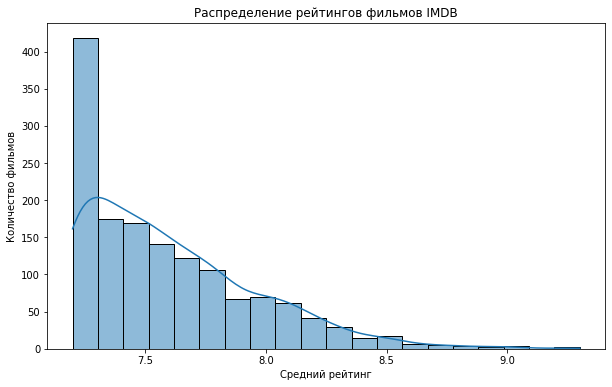

In [19]:
# Гистограмма рейтинга фильмов

plt.figure(figsize=(10, 6))
sns.histplot(df3['average_rating'], bins=20, kde=True)
plt.title("Распределение рейтингов фильмов IMDB")
plt.xlabel("Средний рейтинг")
plt.ylabel("Количество фильмов")
plt.show()

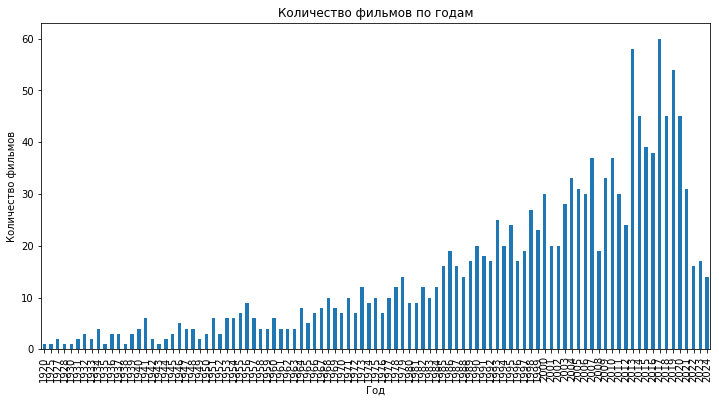

In [21]:
# Гистограмма годов выхода фильмов

plt.figure(figsize=(12, 6))
df3.groupby('release_year').size().plot(kind='bar')
plt.title("Количество фильмов по годам")
plt.xlabel("Год")
plt.ylabel("Количество фильмов")
plt.show()

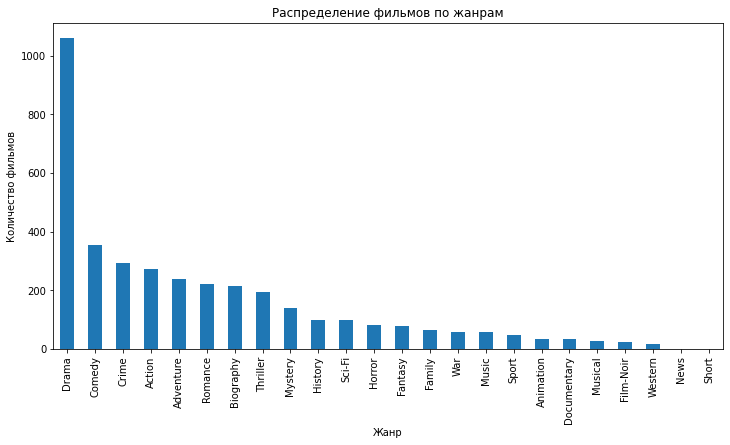

In [23]:
#Анализ по жанрам

# Разбиваем строки столбца 'genre' на отдельные жанры
df_genres = df3['genre'].str.split(',', expand=True)  # Разбиваем по запятой
df_genres = df_genres.stack().str.strip().reset_index(level=1, drop=True).to_frame('genre')

# Подсчитываем количество фильмов для каждого жанра
genre_counts = df_genres['genre'].value_counts()

# Строим график
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar')
plt.title("Распределение фильмов по жанрам")
plt.xlabel("Жанр")
plt.ylabel("Количество фильмов")
plt.show()


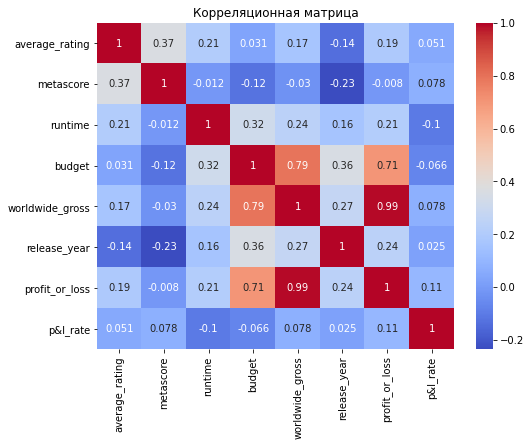

In [24]:
#Корреляционная матрица

plt.figure(figsize=(8, 6))
sns.heatmap(df3.corr(), annot=True, cmap='coolwarm')
plt.title("Корреляционная матрица")
plt.show()

In [25]:
# Выводы по анализу корреляционных пар: чем выше бюджет (budget), тем, как правило, выше кассовые сборы (worldwide_gross)

In [30]:
# Разбиение актеров построчно в новом датафрейме df_cast

df_cast = df3[['title', 'cast']].copy()

# Разбиваем строку на список актёров
df_cast['cast_list'] = df_cast['cast'].apply(lambda x: [actor.strip() for actor in x.split(',')])

# "Взрываем" список, чтобы каждая строка соответствовала одному актёру
df_cast_exploded = df_cast.explode('cast_list').reset_index(drop=True)

df_cast_exploded.head()


,title,cast,cast_list
0,The Shawshank Redemption,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Tim Robbins
1,The Shawshank Redemption,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Morgan Freeman
2,The Shawshank Redemption,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Bob Gunton
3,The Shawshank Redemption,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",William Sadler
4,The Shawshank Redemption,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Clancy Brown


In [32]:
# Формирование рейтинга актера по участию в главных ролях

# Выборка столбцов 'title' и 'cast'
df_cast = df3[['title', 'cast']].copy()

# Разбиваем строку со списком актёров на список, удаляя лишние пробелы
df_cast['cast_list'] = df_cast['cast'].apply(lambda x: [actor.strip() for actor in x.split(',')])

# "Взрываем" список: создаем строку для каждого актёра в фильме
df_cast_exploded = df_cast.explode('cast_list').reset_index(drop=True)

# Группируем по названию фильма и нумеруем актёров (порядок определяется исходным порядком в строке)
df_cast_exploded['rank_in_film'] = df_cast_exploded.groupby('title').cumcount() + 1

df_cast_exploded.head()


,title,cast,cast_list,rank_in_film
0,The Shawshank Redemption,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Tim Robbins,1
1,The Shawshank Redemption,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Morgan Freeman,2
2,The Shawshank Redemption,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Bob Gunton,3
3,The Shawshank Redemption,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",William Sadler,4
4,The Shawshank Redemption,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Clancy Brown,5


In [36]:
# Частота появления актёров в фильмах

actor_counts = df_cast_exploded['cast_list'].value_counts()
print(actor_counts.head(10))

Robert De Niro       26
Willem Dafoe         22
Tom Hanks            22
Brad Pitt            22
Michael Caine        21
Samuel L. Jackson    21
Ralph Fiennes        18
Cate Blanchett       18
Denzel Washington    18
Matt Damon           18
Name: cast_list, dtype: int64


In [41]:
# Связь актёров и рейтинга/бюджета

df_merged = df_cast_exploded.merge(df3[['title', 'average_rating', 'budget']], on='title', how='left')
print(df_merged)

                          title  \
0      The Shawshank Redemption   
1      The Shawshank Redemption   
2      The Shawshank Redemption   
3      The Shawshank Redemption   
4      The Shawshank Redemption   
...                         ...   
26081                Irina Palm   
26082                Irina Palm   
26083                Irina Palm   
26084                Irina Palm   
26085                Irina Palm   

                                                    cast       cast_list  \
0      Tim Robbins, Morgan Freeman, Bob Gunton, Willi...     Tim Robbins   
1      Tim Robbins, Morgan Freeman, Bob Gunton, Willi...  Morgan Freeman   
2      Tim Robbins, Morgan Freeman, Bob Gunton, Willi...      Bob Gunton   
3      Tim Robbins, Morgan Freeman, Bob Gunton, Willi...  William Sadler   
4      Tim Robbins, Morgan Freeman, Bob Gunton, Willi...    Clancy Brown   
...                                                  ...             ...   
26081  Marianne Faithfull, Predrag 'Miki' Manoj

In [42]:
# Средний рейтинг по актёрам
actor_rating = df_merged.groupby('cast_list')['average_rating'].mean().sort_values(ascending=False)
print(actor_rating)

cast_list
Neil Giuntoli          9.3
Larry Brandenburg      9.3
Scott Mann             9.3
Gil Bellows            9.3
Joseph Ragno           9.3
                      ... 
Christopher Owen       7.2
Noël Coward            7.2
Christopher Nilsson    7.2
Sunshine Parker        7.2
Mark St. Cyr           7.2
Name: average_rating, Length: 18124, dtype: float64


In [43]:
# Средний бюджет фильмов, в которых снимался актёр
actor_budget = df_merged.groupby('cast_list')['budget'].mean().sort_values(ascending=False)
print(actor_budget)

cast_list
Simone Ashley               355100000.0
Halle Bailey                355100000.0
Jonah Hauer-King            355100000.0
Martina Laird               355100000.0
Noma Dumezweni              355100000.0
                               ...     
Mohsen Tabandeh                  2500.0
Mohammed-Reza Gharebaghi         2500.0
Mohammad Kheir-abadi             2500.0
Ali Roshan                       2500.0
Masoud Gheyas-vand               2500.0
Name: budget, Length: 18124, dtype: float64


In [44]:
# Распределение «главных ролей»

main_roles = df_cast_exploded[df_cast_exploded['rank_in_film'] == 1]
main_roles_count = main_roles['cast_list'].value_counts().head(10)
print(main_roles_count)

Tom Hanks            18
Robert De Niro       16
Leonardo DiCaprio    15
Tom Cruise           15
Johnny Depp          13
Denzel Washington    13
Brad Pitt            12
Christian Bale       12
Al Pacino            10
Kevin Costner         9
Name: cast_list, dtype: int64


In [47]:
actor_stats = df_merged.groupby('cast_list').agg({
    'average_rating': 'mean',
    'budget': 'mean',
    'title': 'count'
}).rename(columns={'title': 'movies_count'})

# Сортируем по числу фильмов
actor_stats = actor_stats.sort_values(by='movies_count', ascending=False)
actor_stats.head(10)


,average_rating,budget,movies_count
cast_list,,,
Robert De Niro,7.761538,3.966538e+07,26
Tom Hanks,7.763636,6.359091e+07,22
Brad Pitt,7.713636,5.942727e+07,22
Willem Dafoe,7.581818,4.450909e+07,22
Michael Caine,7.785714,7.290238e+07,21
Samuel L. Jackson,7.676190,7.892857e+07,21
Ralph Fiennes,7.638889,7.094444e+07,18
Denzel Washington,7.511111,3.630556e+07,18
Cate Blanchett,7.700000,8.526667e+07,18


In [48]:
# Группируем фильмы по режиссеру и вычисляем средний рейтинг
director_rating = df3.groupby('director')['average_rating'].mean().reset_index()

# Переименовываем столбец, чтобы он отражал рейтинг режиссера
director_rating = director_rating.rename(columns={'average_rating': 'director_rating'})

# Объединяем исходный DataFrame с рейтингом режиссеров по столбцу 'director'
df3 = df3.merge(director_rating, on='director', how='left')

# Просмотр первых строк
print(df3.head())


                      title  average_rating              director  \
0  The Shawshank Redemption             9.3        Frank Darabont   
1             The Godfather             9.2  Francis Ford Coppola   
2           The Dark Knight             9.0     Christopher Nolan   
3          Schindler's List             9.0      Steven Spielberg   
4              12 Angry Men             9.0          Sidney Lumet   

                                              writer  metascore  \
0                       Stephen King, Frank Darabont         82   
1                   Mario Puzo, Francis Ford Coppola        100   
2  Jonathan Nolan, Christopher Nolan, David S. Goyer         84   
3                   Thomas Keneally, Steven Zaillian         95   
4                                      Reginald Rose         97   

                                                cast  \
0  Tim Robbins, Morgan Freeman, Bob Gunton, Willi...   
1  Marlon Brando, Al Pacino, James Caan, Diane Ke...   
2  Christian B

In [50]:
# Фильтр актеров главных ролей

# Отбираем строки, где актёр является одним из двух главных
df_main = df_merged[df_merged['rank_in_film'] <= 2].copy()

# Группируем по актёрам и считаем средний рейтинг для главных ролей
actor_main_rating = df_main.groupby('cast_list')['average_rating'].mean().rename('actor_rating').reset_index()

# Добавляем рассчитанный рейтинг актёра в DataFrame с главными ролями
df_main = df_main.merge(actor_main_rating, on='cast_list', how='left')

# Группируем по фильму и рассчитываем среднее значение рейтингов главных актеров
film_main_actors_rating = df_main.groupby('title')['actor_rating'].mean().reset_index().rename(columns={'actor_rating': 'main_actors_rating'})

# Добавим рассчитанный столбец main_actors_rating обратно в основной DataFrame фильмов (df3):
df3 = df3.merge(film_main_actors_rating, on='title', how='left')



In [51]:
# Расчет корреляции для режиссеров
corr_director = df3[['director_rating', 'p&l_rate']].corr().iloc[0,1]

# Расчет корреляции для главных актеров
corr_actors = df3[['main_actors_rating', 'p&l_rate']].corr().iloc[0,1]

print("Корреляция между director_rating и p&l_rate:", corr_director)
print("Корреляция между main_actors_rating и p&l_rate:", corr_actors)


Корреляция между director_rating и p&l_rate: -0.02234848822124211
Корреляция между main_actors_rating и p&l_rate: -0.013790710375037579


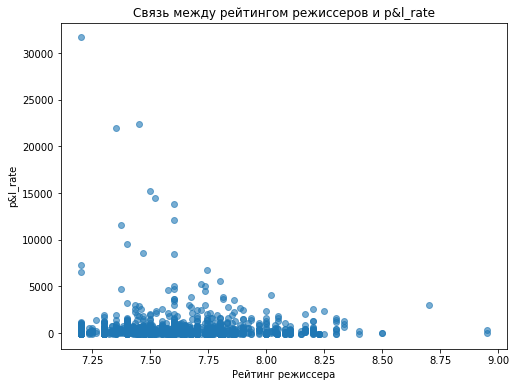

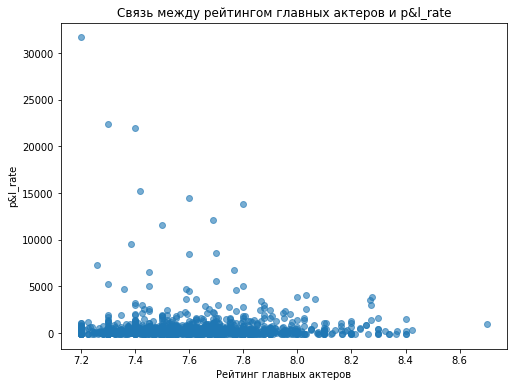

In [52]:
# График для режиссеров
plt.figure(figsize=(8,6))
plt.scatter(df3['director_rating'], df3['p&l_rate'], alpha=0.6)
plt.title("Связь между рейтингом режиссеров и p&l_rate")
plt.xlabel("Рейтинг режиссера")
plt.ylabel("p&l_rate")
plt.show()

# График для главных актеров
plt.figure(figsize=(8,6))
plt.scatter(df3['main_actors_rating'], df3['p&l_rate'], alpha=0.6)
plt.title("Связь между рейтингом главных актеров и p&l_rate")
plt.xlabel("Рейтинг главных актеров")
plt.ylabel("p&l_rate")
plt.show()


In [58]:
# Создаём словарь соответствия "страна → континент"
continent_dict = {
    # Африка
    "Algeria": "Africa",
    "Botswana": "Africa",
    "Egypt": "Africa",
    "Gambia": "Africa",
    "Kenya": "Africa",
    "Morocco": "Africa",
    "South Africa": "Africa",
    "Zimbabwe": "Africa",
    
    # Азия
    "China": "Asia",
    "Hong Kong": "Asia",
    "India": "Asia",
    "Iran": "Asia",
    "Israel": "Asia",
    "Japan": "Asia",
    "Jordan": "Asia",
    "Kazakhstan": "Asia",
    "Lebanon": "Asia",
    "Occupied Palestinian Territory": "Asia",
    "Qatar": "Asia",
    "Singapore": "Asia",
    "South Korea": "Asia",
    "Taiwan": "Asia",
    "Thailand": "Asia",
    "Turkey": "Asia",
    "United Arab Emirates": "Asia",
    
    # Европа
    "Austria": "Europe",
    "Belgium": "Europe",
    "Bulgaria": "Europe",
    "Cyprus": "Europe",
    "Czech Republic": "Europe",
    "Denmark": "Europe",
    "Federal Republic of Yugoslavia": "Europe",
    "Finland": "Europe",
    "France": "Europe",
    "Germany": "Europe",
    "Greece": "Europe",
    "Hungary": "Europe",
    "Iceland": "Europe",
    "Ireland": "Europe",
    "Italy": "Europe",
    "Latvia": "Europe",
    "Luxembourg": "Europe",
    "Malta": "Europe",
    "Netherlands": "Europe",
    "Norway": "Europe",
    "Poland": "Europe",
    "Romania": "Europe",
    "Russia": "Europe",
    "Serbia": "Europe",
    "Slovakia": "Europe",
    "Soviet Union": "Europe",
    "Spain": "Europe",
    "Sweden": "Europe",
    "Switzerland": "Europe",
    "Ukraine": "Europe",
    "United Kingdom": "Europe",
    "West Germany": "Europe",
    "Yugoslavia": "Europe",
    
    # Северная Америка
    "Bahamas": "North America",
    "Canada": "North America",
    "Mexico": "North America",
    "Panama": "North America",
    "United States": "North America",
    
    # Южная Америка
    "Argentina": "South America",
    "Brazil": "South America",
    "Chile": "South America",
    "Colombia": "South America",
    "Ecuador": "South America",
    "Venezuela": "South America",
    
    # Австралия и Океания
    "Australia": "Australia and Oceania",
    "New Zealand": "Australia and Oceania"
}

# Убедимся, что в DataFrame название столбца именно 'country_of_origin'
# Сначала уберём лишние пробелы в названии страны (strip)
df3['country_of_origin'] = df3['country_of_origin'].str.strip()

# Создадим новый столбец 'continent'
df3['continent'] = df3['country_of_origin'].map(continent_dict).fillna('Other')

# Вывод DataFrame
df3[['continent', 'p&l_rate']].head()


,continent,p&l_rate
0,North America,17.33
1,North America,4072.37
2,Other,445.43
3,North America,1364.37
4,North America,-99.16
